In [ ]:
!pip install bertopic
!pip install -U numpy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from bertopic import BERTopic
import pandas as pd
from collections import defaultdict
import random
from itertools import chain
import pickle
from tqdm import tqdm
from collections import Counter
from operator import itemgetter
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# CONSTANTS

random.seed(42)

# Quotebank years list
YEARS = range(2015, 2021)

# Path to filtered quotebank dataset (one party per speaker)
QUOTEBANK_ONE_PARTY = {year: f"/content/drive/MyDrive/Quotebank_sets/ADA_data/quotebank_one_party-{year}.csv" for year in YEARS}

# Maximum number of quotes per party in each of the 6 years
MAX_QUOTES_PER_PARTY = [170, 225, 155, 145, 145, 530]

# Path to fitted models by year
FITTED_BERT_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_models/{year}_topic_model' for year in YEARS}

# Path to quotes per year used for fitting
FITTED_QUOTES_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_data/{year}_fit_data.pkl' for year in YEARS}

# Path to topics for quotes, per year
QUOTES_TOPICS_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_models/{year}_all_topics.pkl' for year in YEARS}

# Path to final quotes with named topics dataframe
FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_data/final-quotes-named-topics-{year}.csv' for year in YEARS}



In [4]:
# HELPERS

def choose_quotes(row, max_quotes):
    """
    If number of quotes per party below max_quotes, select all,
    otherwise select randomly max_quotes quotes for a party.
    """
    if not row['select_all']:
        # Randomly sample max_quotes quotes
        row['quotes_list'] = random.sample(row['quotes_list'], max_quotes)
        row['number'] = max_quotes
    return row


def get_quotes_for_year_fit():
    """
    Get yearly political parties quotes required for fitting BERTopic.
    """
    # Dictionary with quotes per year (around 100K quotes for each year)
    quotes_by_year = defaultdict(list)

    for i, quote_year in tqdm(enumerate(YEARS)):
        df = pd.read_csv(QUOTEBANK_ONE_PARTY[quote_year], index_col=[0])
        # Group by party
        groupby_party = df.groupby('party_one')['quotation'].agg(quotes_list=list, number=len)
        # Create boolean column with True values if number of quotes for party is above threshold
        groupby_party['select_all'] = groupby_party['number'] <= MAX_QUOTES_PER_PARTY[i]
        # Create a the list of quotes for a year
        quotes = groupby_party.apply(lambda x: choose_quotes(x, MAX_QUOTES_PER_PARTY[i]), axis=1)['quotes_list'].values
        quotes = list(chain.from_iterable(quotes))
        quotes_by_year[quote_year] = quotes
        # Also save data used for fiiting because we need it later
        with open(FITTED_QUOTES_PER_YEAR_PATH[quote_year], 'wb') as f:
            pickle.dump(quotes, f)

    return quotes_by_year


def fit_years(start_year, end_year):
    """
    Function for fiting BERTopic on quotes from each year.
    """
    yearly_quotes = get_quotes_for_year_fit()
    for i, quote_year in enumerate(range(start_year, end_year)):
        # Instantiate BERTopic
        topic_model = BERTopic(verbose=True)
        # Fit a model on topics of each year
        topics = topic_model.fit(yearly_quotes[quote_year])
        print(f'Saving model for {quote_year}')
        # Save model
        topic_model.save(FITTED_BERT_PER_YEAR_PATH[quote_year])


def transform_years(models_by_year, quotes_by_year):
    """
    Function for predicting topics on quotes from each year.
    """
    for year in models_by_year.keys():
        model_topics_all, model_probs_all = models_by_year[year].transform(quotes_by_year[year])
        with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'wb') as f:
            pickle.dump([model_topics_all, model_probs_all], f)


def get_all_quotes_for_year(year, return_quote_ids=False):
    """
    Get all quotes from a year.
    """
    df = pd.read_csv(QUOTEBANK_ONE_PARTY[year])
    if len(df) > 1600000:
        print("Reduced to 1.6 M quotes")
        df = df.sample(1600000, axis=0)
    res = df[['quoteID', 'quotation']]
    if return_quote_ids:
        return res['quotation'].tolist(), res['quoteID'].tolist()
    else:
        return res['quotation'].tolist(), None

In [ ]:
def per_years_analysis(fit_all_first=False, transform_all_first=False, start_year=2015, end_year=2021):
    # Fit models first, if necessary
    if fit_first:
        fit_years(start_year, end_year)

    # Instantiate a BERTopic model for each year
    models = {}
    quotes_all = {}
    for year in range(start_year, end_year):
        # Store models for each year
        models[year] = BERTopic(verbose=True).load(FITTED_BERT_PER_YEAR_PATH[year])
        # Get all quotes for each year
        year_quotes, year_quote_id = get_all_quotes_for_year(year, return_quote_ids=False)
        quotes_all[year] = year_quotes

    # Predict topics on each year quotes, if necessary
    if transform_first:
        transform_years(models, quotes_all)

    for year in range(start_year, end_year):
        # Get quotes topics
        with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'rb') as topic_file:
            model_topics_all, model_probs_all = pickle.load(topic_file)

        # Remove quotes which are not clustered into a topic
        quotes_all = [x for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
        model_probs_all = [x for i, x in enumerate(model_probs_all) if model_topics_all[i] != -1]
        model_topics_all = [x for x in model_topics_all if x != -1]

        # Automatic reduction


        # Manual reduction


In [192]:
models = {}
quotes_all = {}
year = 2019
models[year] = BERTopic(verbose=True).load(FITTED_BERT_PER_YEAR_PATH[year])
year_quotes, year_quote_id = get_all_quotes_for_year(year, return_quote_ids=True)
quotes_all[year] = year_quotes
# transform_years(models, quotes_all)

In [190]:
with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'rb') as topic_file:
            model_topics_all, model_probs_all = pickle.load(topic_file)

In [191]:
# Number of quotes right after transform
print(len(quotes_all[year]))
print(len(model_topics_all))

1600000
1644663


In [16]:
# Number of quotes after removing non-clustered ones
only_clustered = [x for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
only_clustered_id = [year_quote_id[i] for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
print(len(only_clustered))
# model_probs_all = [x for i, x in enumerate(model_probs_all) if model_topics_all[i] != -1]
model_topics_all = [x for x in model_topics_all if x != -1]
print(len(model_topics_all))

693962
693962


For 2015 - 669642 quotes clustered
For 2018 - 693962 quotes clustered

For 2015 - 1641 parties
For 2018 - 1671 parties

In [17]:
new_topics, new_probs = models[year].reduce_topics(only_clustered, model_topics_all, nr_topics=80)

2021-12-12 17:54:59,342 - BERTopic - Reduced number of topics from 798 to 81


In [18]:
quote_to_topic_df = pd.DataFrame({'quote_id': only_clustered_id, 'quote': only_clustered, 'topic': new_topics}). set_index('quote_id')
quote_to_topic_df

,quote,topic
quote_id,,
2019-06-14-041192,"I wasn't mad at the president,",41
2019-11-17-016521,I have learnt that the meeting (of NDA constit...,0
2019-12-11-047085,It is alarming that these sensors failed on mu...,76
2019-05-07-009357,"Backed by a $41 million commitment, this strat...",1
2019-10-22-059755,mass mobilization of working-class people at t...,7
...,...,...
2019-07-26-080076,Without a detailed engineering plan you cannot...,38
2019-04-05-077943,"Right now in our state constitution, we've got...",21
2019-05-24-035924,I know initially people thought this was month...,26


In [181]:
quote_to_topic_df[quote_to_topic_df['topic'] == 13].iloc[224].quote

"Dear Donald. It's been a busy year! Enjoy the Christmas holidays -- you deserve it,"

In [172]:
models[year].get_topic(13)

[('veterans', 0.02416123971132622),
 ('christmas', 0.011431923510700617),
 ('honor', 0.010919661084387989),
 ('festival', 0.010055612257435464),
 ('celebrate', 0.009206311143432367),
 ('sacrifice', 0.00789187875900572),
 ('award', 0.007421632982538049),
 ('grateful', 0.007304166501966379),
 ('heritage', 0.006402935904730597),
 ('gratitude', 0.005380917852555059)]

In [182]:
# 2019 labels
s = [
'0 - indian politics',
'1 - healthcare',
'2 - women',
'3 - education',
'4 - transportation',
'5 - southern asia',
'6 - brexit',
'7 - voting/elections',
'8 - australia/oceania',
'9 - abortion',
'10 - war and violence (peace)',
'11 - tourism',
'12 - senate',
'13 - veterans/patriotism/celebration',
'14 - south-america',
'15 - law enforcement',
'16 - illegal substances',
'17 - turkey/syria',
'18 - communication/leadership',
'19 - lgbt/gender equality',
'20 - uk',
'21 - corruption/crimes',
'22 - canada',
'23 - israel/palestine',
'24 - european union',
'25 - filipines',
'26 - policies',
'27 - russia',
'28 - pakistan/afghanistan',
'29 - parties',
'30 - immigration/refugees',
'31 - ministers',
'32 - border/wall',
'33 - meetings/public relations',
'34 - terrorism',
'35 - unions',
'36 - national organizations/international cooperation',
'37 - sea-life/fishing',
'38 - flooding',
'39 - agriculture',
'40 - governmnet/president',
'41 - apologize/regret',
'42 - guns',
'43 - challenges/lies',
'44 - tax',
'45 - economy',
'46 - climate change',
'47 - smoking',
'48 - india',
'49 - econimic situation/banks',
'50 - investigations',
'51 - rights/freedom',
'52 - parliament',
'53 - military/middle-east',
'54 - community support/suicides',
'55 - africa',
'56 - security',
'57 - communication/speech',
'58 - racism',
'59 - social networks/devices',
'60 - resignation/strikes',
'61 - nigeria',
'62 - safety',
'63 - councils',
'64 - imports/exports',
'65 - regulations',
'66 - budget/spendings',
'67 - justice',
'68 - media',
'69 - jews',
'70 - negotiations',
'71 - housing/homelessness',
'72 - natural resources/recycling',
'73 - renewable energy',
'74 - malaysia/singapore',
'75 - race/racing/color',
'76 - aviation',
'77 - sports',
'78 - urban areas/mayors',
'79 - crisis/disasters',
'80 - science/progress'
]
d = {}
for ss in s:
    k, v = ss.split(' - ')
    d[int(k)] = v
topic_mapping = pd.DataFrame({'topic_number': d.keys(), 'topic_name':d.values()}).set_index('topic_number')

In [ ]:
# 2015 labels
s = [
'0 - education',
'1 - transportation',
'2 - women',
'3 - communication/public relations',
'4 - crimes',
'5 - southern asia',
'6 - community/leadership',
'7 - iran/russia',
'8 - sports',
'9 - refugees/immigrants',
'10 - india',
'11 - media',
'12 - european union',
'13 - diseases/vaccines',
'14 - gender equality',
'15 - ministers',
'16 - war and violence (peace)',
'17 - negotiations',
'18 - healthcare',
'19 - voting/elections',
'20 - canada',
'21 - planning/proposals',
'22 - democracy',
'23 - economy',
'24 - israel/palestine',
'25 - africa',
'26 - filipines',
'27 - malaysia/singapore',
'28 - illegal substances',
'29 - employment/wages',
'30 - kids/family',
'31 - uk',
'32 - middle-east',
'33 - energy',
'34 - justice',
'35 - tax',
'36 - national organizations/international cooperation',
'37 - parliament',
'38 - politics',
'39 - terrorism',
'40 - australia/oceania',
'41 - government',
'42 - legislation',
'43 - rights/freedom',
'44 - loan/debts',
'45 - food/hunger',
'46 - religion',
'47 - policies/regulations',
'48 - east-asia',
'49 - sea-life/fishing',
'50 - south-america',
'51 - agriculture',
'52 - urban areas/mayors',
'53 - business and innovation',
'54 - pollution',
'55 - syria/isis',
'56 - flooding',
'57 - abortion',
'58 - councils/meetings',
'59 - islam',
'60 - law enforcement',
'61 - france/terrorism',
'62 - climate change',
'63 - apologize/regret',
'64 - senate',
'65 - island countries',
'66 - lgbt',
'67 - problems/solutions',
'68 - veterans/patriotism',
'69 - parties',
'70 - markets',
'71 - economic sitaution',
'72 - budget/spendings',
'73 - natural disasters',
'74 - housing/homelessness',
'75 - renewable energy',
'76 - guns/shootings',
'77 - aviation',
'78 - protests',
'79 - science/progress',
'80 - unions'
]
d = {}
for ss in s:
    k, v = ss.split(' - ')
    d[int(k)] = v
topic_mapping = pd.DataFrame({'topic_number': d.keys(), 'topic_name':d.values()}).set_index('topic_number')

In [183]:
df_original = pd.read_csv(QUOTEBANK_ONE_PARTY[year], index_col=[0]).set_index('quoteID')
final_df = df_original.merge(quote_to_topic_df[['topic']], how='inner', left_index=True, right_index=True)
final_df = final_df.merge(topic_mapping, how='inner', left_on='topic', right_index=True)
final_df.to_csv(FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH[year])

In [9]:
year = 2019

In [19]:
final_df = pd.read_csv(FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH[year], index_col=[0])

,quotation,qids,party,party_qcodes,party_one,speaker,topic,topic_name
2019-06-28-043094,It is my view that the answer to their problem...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-04-04-097232,The flow of illicit fentanyl largely from Chin...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-10-18-068133,Our situation in these prisons is very difficu...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-09-11-017333,Do you believe the United States has committed...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-04-09-061930,legalized trafficking of persons.,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances


In [20]:
# Remove independent politicians
final_df = final_df[final_df['party_one'] != 'independent politician']
final_df.head()

,quotation,qids,party,party_qcodes,party_one,speaker,topic,topic_name
2019-06-28-043094,It is my view that the answer to their problem...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-04-04-097232,The flow of illicit fentanyl largely from Chin...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-10-18-068133,Our situation in these prisons is very difficu...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-09-11-017333,Do you believe the United States has committed...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-04-09-061930,legalized trafficking of persons.,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances


In [21]:
topic_count_per_year = Counter(final_df['topic_name'])
most_common_topics = dict(topic_count_per_year.most_common())
most_common_topics = pd.DataFrame({'subject': most_common_topics.keys(), 'nr_quotes': most_common_topics.values()})
most_common_topics[:20]

,subject,nr_quotes
0,indian politics,31091
1,healthcare,24938
2,women,22111
3,education,20988
4,transportation,18211
5,east asia,16289
6,brexit,14524
7,voting/elections,13607
8,australia/oceania,13380
9,abortion,12459


In [22]:
party_to_topics = final_df.groupby(['party_one', 'topic_name']).count()['quotation']

In [23]:
party_to_topics['Democratic Party'].sort_values(ascending=False)[:25]

topic_name
healthcare                         7856
women                              7768
education                          6421
senate                             4677
abortion                           4656
transportation                     4332
voting/elections                   3795
lgbt/gender equality               3723
guns                               3410
illegal substances                 3085
tourism                            3033
smoking                            2954
veterans/patriotism/celebration    2777
law enforcement                    2718
climate change                     2689
policies                           2681
governmnet/president               2625
corruption/crimes                  2504
communication/leadership           2491
war and violence (peace)           2441
tax                                2423
urban areas/mayors                 2402
immigration/refugees               2397
racism                             2391
border/wall                  

In [24]:
party_to_topics['Republican Party'].sort_values(ascending=False)[:25]

topic_name
east asia                          5780
women                              4999
healthcare                         4436
education                          4227
senate                             3824
border/wall                        3219
abortion                           3211
russia                             3036
turkey/syria                       2865
south-america                      2744
war and violence (peace)           2742
military/middle-east               2731
illegal substances                 2599
veterans/patriotism/celebration    2432
transportation                     2317
imports/exports                    2310
voting/elections                   2258
governmnet/president               2250
policies                           2156
tourism                            2135
communication/leadership           2031
investigations                     1978
smoking                            1964
immigration/refugees               1950
corruption/crimes            

In [37]:
most_important_k = 20
less_important_parties = list(dict(Counter(final_df['party_one']).most_common()[most_important_k:]).keys())
party_to_topics_df = pd.DataFrame(party_to_topics).rename(columns={'quotation': 'nr_quotes'})
party_to_topics_df = party_to_topics_df.drop(less_important_parties, level=0)
party_to_topics_df

nr_quotes
party_one                 topic_name                                
African National Congress abortion                                60
                          africa                                 598
                          agriculture                             24
                          apologize/regret                        68
                          australia/oceania                        6
...                                                              ...
Scottish National Party   urban areas/mayors                       8
                          veterans/patriotism/celebration         73
                          voting/elections                       144
                          war and violence (peace)                37
                          women                                  221

[1592 rows x 1 columns]

In [38]:
quotes_per_party = party_to_topics_df.groupby(level=0).sum()
party_to_topics_df = party_to_topics_df.merge(quotes_per_party, how='inner', right_index=True, left_on='party_one', suffixes=['', '_total'])
party_to_topics_df['party_quotes_percentage'] = (party_to_topics_df['nr_quotes'] / party_to_topics_df['nr_quotes_total']) * 100
party_to_topics_df

nr_quotes  ...  party_quotes_percentage
party_one                 topic_name                                  ...                         
African National Congress abortion                                60  ...                 1.213347
                          africa                                 598  ...                12.093023
                          agriculture                             24  ...                 0.485339
                          apologize/regret                        68  ...                 1.375126
                          australia/oceania                        6  ...                 0.121335
...                                                              ...  ...                      ...
Scottish National Party   urban areas/mayors                       8  ...                 0.122624
                          veterans/patriotism/celebration         73  ...                 1.118945
                          voting/elections                       144  ...                 2.207235
                          war and violence (peace)                37  ...                 0.567137
                          women                                  221  ...                 3.387492

[1592 rows x 3 columns]

In [39]:
party_to_topics_tmp = party_to_topics_df.sort_values(['party_one', 'party_quotes_percentage'], ascending=[True, False]).groupby(level=0).head(60)
party_to_topics_tmp

nr_quotes  ...  party_quotes_percentage
party_one                 topic_name                       ...                         
African National Congress africa                      598  ...                12.093023
                          transportation              266  ...                 5.379171
                          lgbt/gender equality        242  ...                 4.893832
                          education                   230  ...                 4.651163
                          nigeria                     177  ...                 3.579373
...                                                   ...  ...                      ...
Scottish National Party   renewable energy             18  ...                 0.275904
                          sports                       18  ...                 0.275904
                          senate                       17  ...                 0.260576
                          smoking                      15  ...                 0.229920
                          science/progress             14  ...                 0.214592

[1200 rows x 3 columns]

In [40]:
# nodes_size = party_to_topics_tmp.sum(level=[0]).sort_index(ascending=True)
nodes_size = quotes_per_party

In [41]:
# graph_df = pd.DataFrame(party_to_topics_tmp).reset_index().rename(columns={'nr_quotes': "weight", 'party_one': 'party'})
graph_df = pd.DataFrame(party_to_topics_tmp).reset_index().rename(columns={'party_quotes_percentage': "weight", 'party_one': 'party'})
G = nx.convert_matrix.from_pandas_edgelist(graph_df, 'party', 'topic_name', ['weight'])
labels = {i:i for i in dict(G.nodes).keys()}
print(nx.info(G))

Graph with 101 nodes and 1200 edges


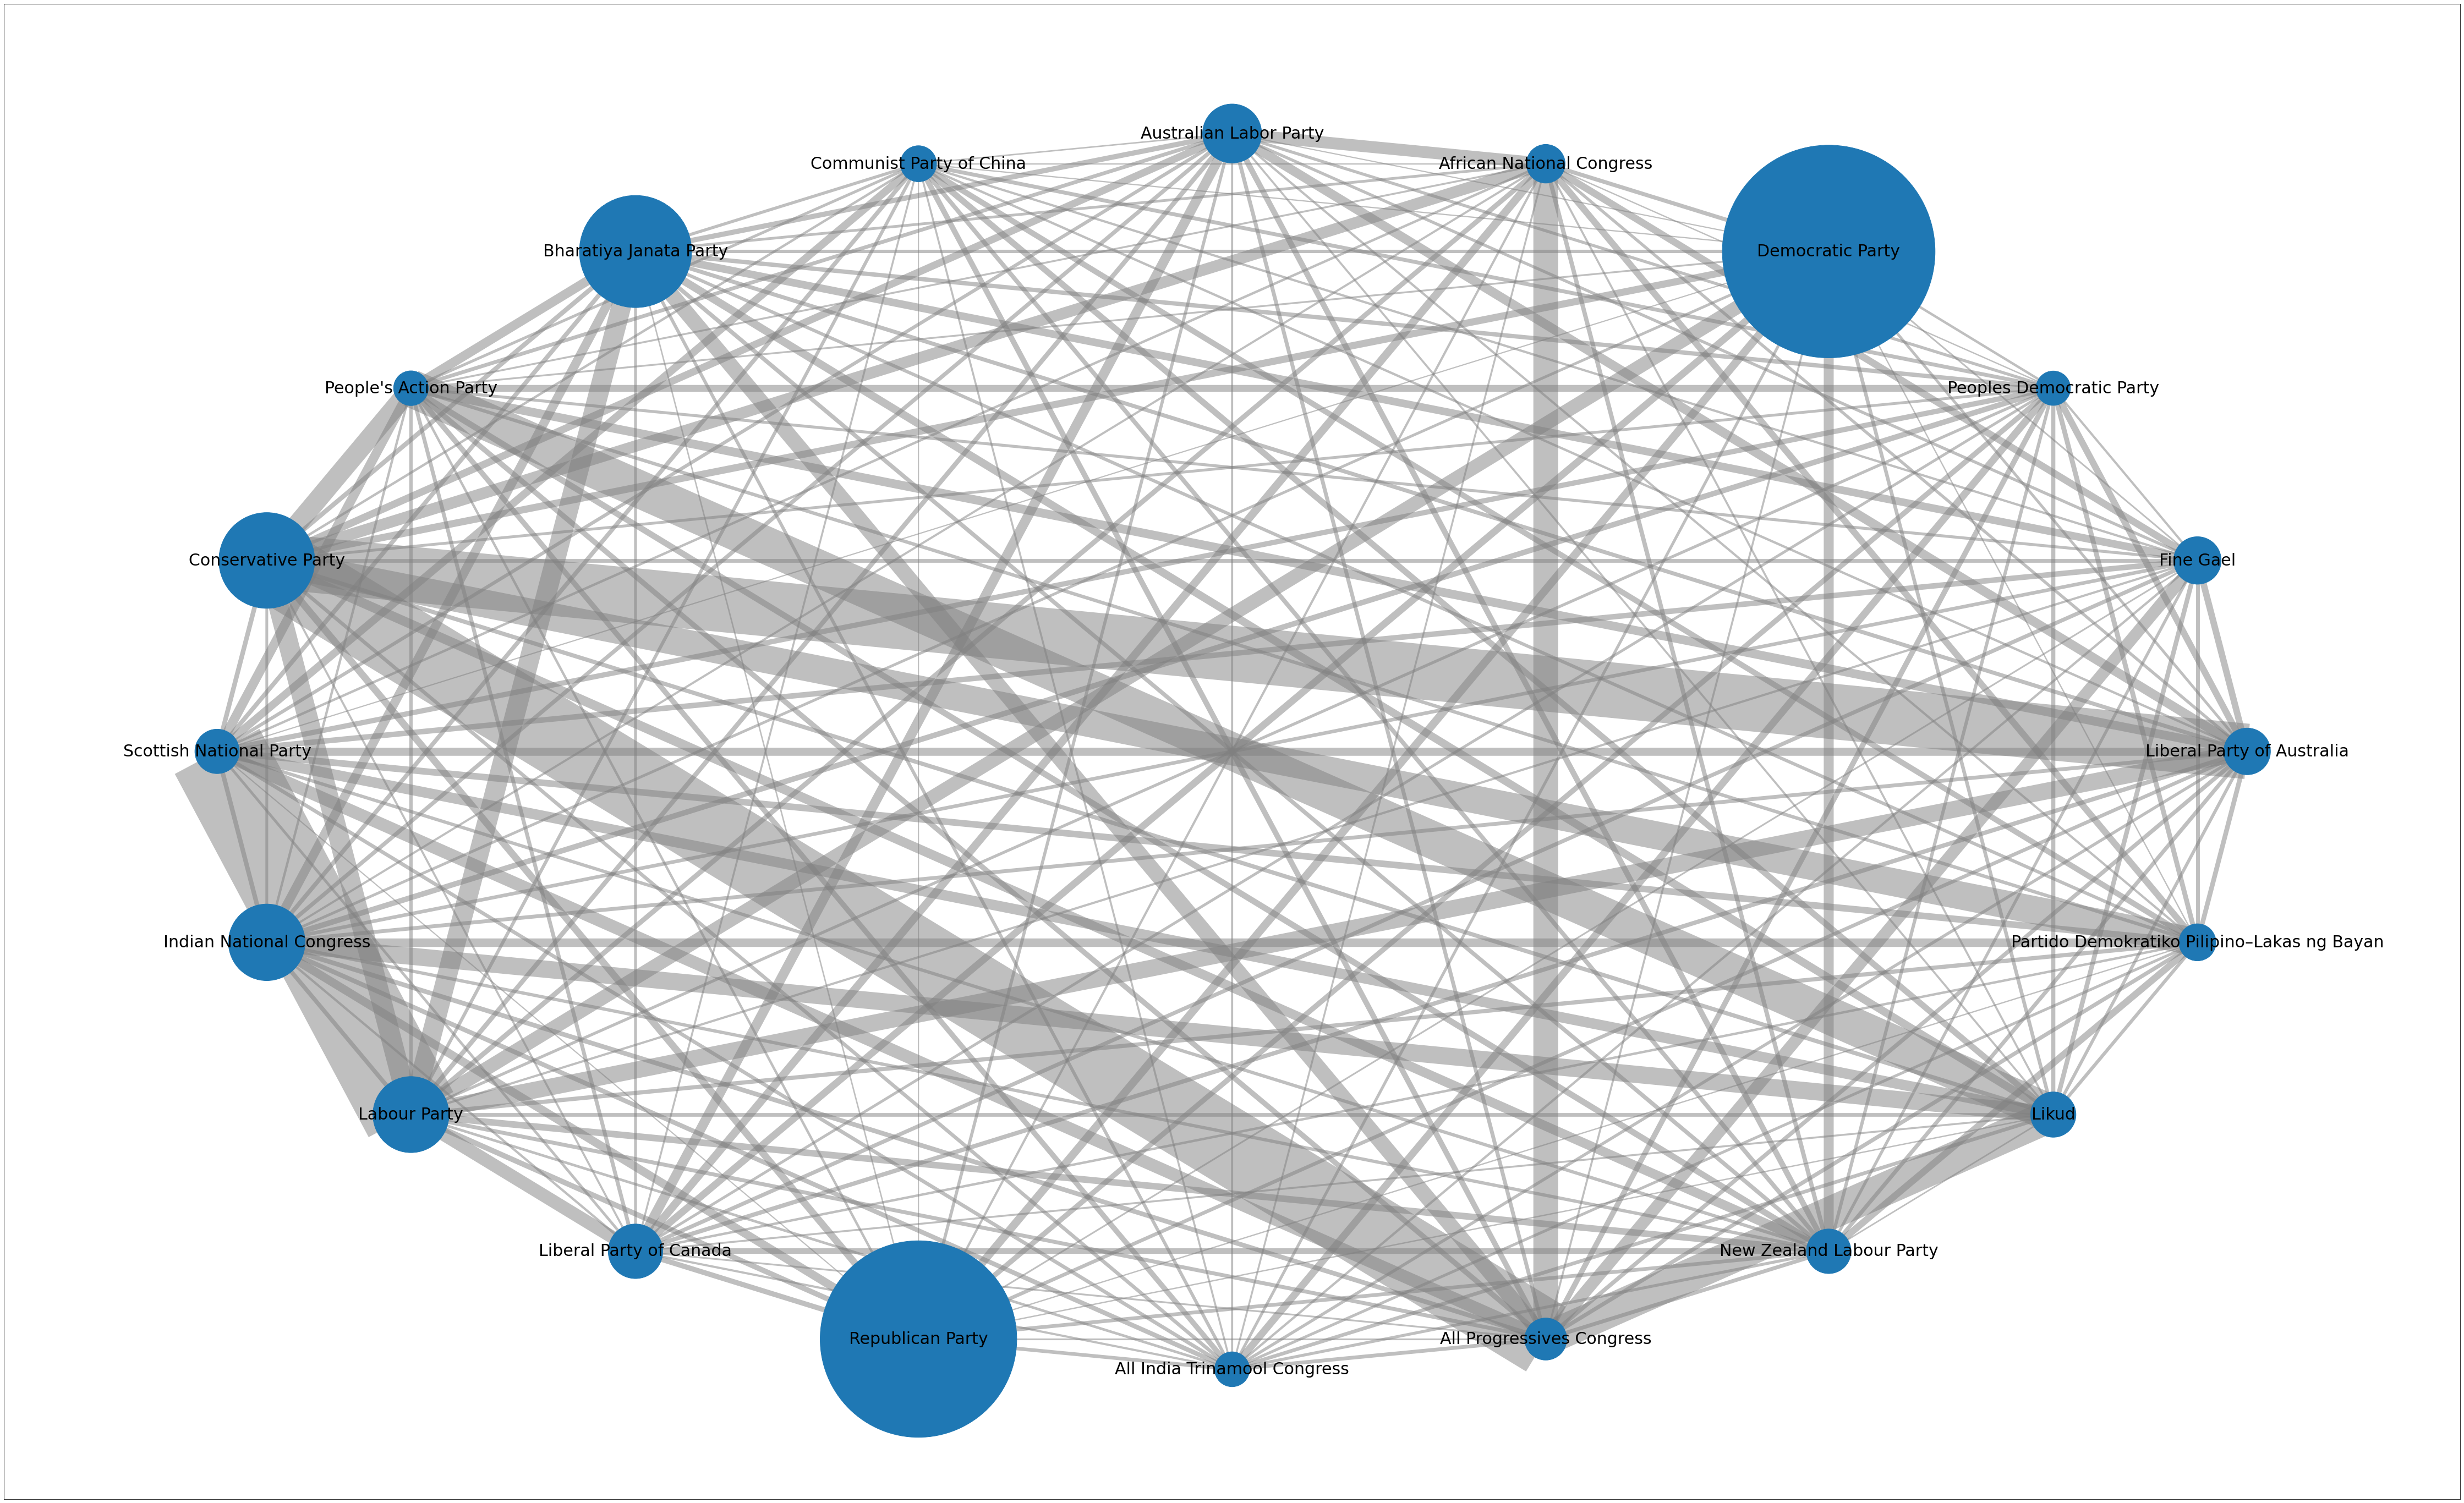

In [42]:
def weight_edges_abs_diff_divide(G, u, v, weight='weight'):
    w = 0
    # print(u, v)
    for nbr in set(G[u]) & set(G[v]):
        w += 1 / (abs(G.edges[u, nbr].get(weight, 0) -  G.edges[v, nbr].get(weight, 0)))
    # print(w)
    return w

def weight_edges_abs_diff_jacard(G, u, v, weight='weight'):
    w = 0
    intersect = 0
    # print(u, v)
    for nbr in set(G[u]) & set(G[v]):
        if abs(G.edges[u, nbr].get(weight, 0) - G.edges[v, nbr].get(weight, 0)) <= 0.5:
            intersect += 1
    w = intersect / len(set(G[u]) & set(G[v])) * 100
    # print(w)
        
    return w

projected_G = nx.algorithms.bipartite.generic_weighted_projected_graph(G, nx.bipartite.sets(G)[0], weight_function=weight_edges_abs_diff_divide)

weights = []
for node1, node2, data in projected_G.edges(data=True):
    # data['weight'] /= 5
    # data['weight'] /= 200
    data['weight'] /= 50

    weights.append(data['weight'])

fig, ax = plt.subplots(figsize=(80,50))
# pos = nx.spring_layout(projected_G)
pos = nx.circular_layout(projected_G)

nx.draw_networkx_nodes(projected_G, pos, ax=ax, node_size=list(map(lambda x: nodes_size.loc[x].values[0], projected_G.nodes())))
nx.draw_networkx_edges(projected_G, pos, ax=ax, width=weights, edge_color='grey', alpha=0.5)
_ = nx.draw_networkx_labels(projected_G, pos, {i:i for i in dict(projected_G.nodes).keys()}, ax=ax, font_size=30)